# Compute fluxes with microbiome compositions and fit ML model to predict traits

Before running this notebook, the following data needs to be acquired...

    - genus asv dataframe
    - community metabolic model
    - sample traits

TO DO:
- Prepare the new metadata file corresponding to the new AGP dataset
- Create functions similar to "gut_data.set_vegan_df()" for different traits
- Save flux outputs for MICOM computations specific to different traits

In [1]:
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedShuffleSplit
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import make_pipeline
## my functions/classes
from mb_xai import mb_utils
import mb_xai.gut_data as gd
from sklearn.decomposition import PCA
from sklearn.feature_selection import f_classif
# import mb_xai.mb_data as gd
# import mb_xai.mb_learn as gl

/Users/erolkavvas/anaconda3/lib/python3.7/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt


In [2]:
FIG_SAVE_LOC = "../figures/"
# DATA_LOC = '../../../Data/community_optimization/data/'
DATA_LOC = '../../../Data/microbiome_xai/'
# DATA_LOC = '../../Data/microbiome_xai/'

In [16]:
gut_data = gd.GutData()
gut_data.load_data(
    # FILE_COMM_MODEL='../data/reconstructions/community_5_TOP-vegan.pickle',
    # FILE_COMM_MODEL= DATA_LOC + 'reconstructions/community_5_TOP-vegan.pickle',
    FILE_COMM_MODEL= DATA_LOC + 'reconstructions/community_50_TOP.pickle',
    # FILE_GENUS_ASVS = "../data/agp_data/taxon_genus_asvs.csv",
    FILE_GENUS_ASVS = DATA_LOC + 'agp_data/taxon_genus_asvs.csv',
    # FILE_METADATA = DATA_LOC + "agp_data/mcdonald_agp_metadata.txt",
    FILE_METADATA = DATA_LOC + "agp_data/metadata_biosample_filtered.csv",
    DIR_SIM_DATA = DATA_LOC + "micom-sim-data/"  # "../data/micom-sim-data/",
)
gut_data.norm_abundances(filter_model=True, add_delta=True) ## Filters genus to those in model, adds small value to abundaces
gut_data.X_df = gut_data.asv_df.T.copy()
gut_data.sample_list = gut_data.X_df.index.to_list()
# gut_data.set_ibs_df(sample_num=20, add_other_diagnosis=False)
gut_data.set_vegan_df(sample_num=200)
## Set vegan df changes X_df and y_df and will therefore change medium_df. Be sure to run medium df after setting samples
medium_df = pd.DataFrame(1000, columns=gut_data.com_model.medium.keys(), index = gut_data.X_df.index)
gut_data.sample_medium_dict = medium_df.T.to_dict()
gut_data.return_fluxes = True
gut_data.pfba_bool = True # otherwise optimum values will not be fluxes but intead min(sum flux)

Fixed EX_tDHNACOA(e)
... normalizing raw ASV abundances to fractions, dropping samples with 0 total abundances
# of genus in model and not filterd out of QA/QC: 50, # of genus not in model:0


# PCA of metabolic fluxes

In [3]:
gut_data = gd.GutData()
gut_data.load_data(
    # FILE_COMM_MODEL='../data/reconstructions/community_5_TOP-vegan.pickle',
    FILE_COMM_MODEL= DATA_LOC + 'reconstructions/community_5_TOP-vegan.pickle',
    # FILE_COMM_MODEL= DATA_LOC + 'reconstructions/community_50_TOP.pickle',
    # FILE_GENUS_ASVS = "../data/agp_data/taxon_genus_asvs.csv",
    FILE_GENUS_ASVS = DATA_LOC + 'agp_data/taxon_genus_asvs.csv',
    # FILE_METADATA = DATA_LOC + "agp_data/mcdonald_agp_metadata.txt",
    FILE_METADATA = DATA_LOC + "agp_data/metadata_biosample_filtered.csv",
    DIR_SIM_DATA = DATA_LOC + "micom-sim-data/"  # "../data/micom-sim-data/",
)
gut_data.norm_abundances(filter_model=True, add_delta=True) ## Filters genus to those in model, adds small value to abundaces
gut_data.X_df = gut_data.asv_df.T.copy()
gut_data.sample_list = gut_data.X_df.index.to_list()
# gut_data.set_ibs_df(sample_num=20, add_other_diagnosis=False)
gut_data.set_vegan_df(sample_num=100)
## Set vegan df changes X_df and y_df and will therefore change medium_df. Be sure to run medium df after setting samples
medium_df = pd.DataFrame(1000, columns=gut_data.com_model.medium.keys(), index = gut_data.X_df.index)
gut_data.sample_medium_dict = medium_df.T.to_dict()
gut_data.return_fluxes = True
gut_data.pfba_bool = True # otherwise optimum values will not be fluxes but intead min(sum flux)

Nothing to fix
... normalizing raw ASV abundances to fractions, dropping samples with 0 total abundances
# of genus in model and not filterd out of QA/QC: 5, # of genus not in model:0


In [4]:
## Takes about 7 minutes for 800 samples on home computer for 5 genus model...
## Crashes with top50 genus model ("function tool longer than 300 seconds")
gut_data.tradeoff_bool = True
gut_data.tradeoff_frac = 0.1
# gut_data.sample_list = gut_data.X_df.index[:10].to_list() # using 10 samples in this case
gut_data.run_micom_samples_parallel(gut_data.com_model, processes=gd.cpu_count(), atol=1e-6)
## Save fluxes
gut_data.fluxes.to_csv(gut_data.dir_sim_data+"micom_fluxes-top5-%d_samples.csv"%(len(gut_data.sample_list)))

In [5]:
gut_data.fluxes.head()

react,12DGR180tex__alistipes,12DGR180tipp__alistipes,12PPD_Stex__alistipes,12PPDtpp__alistipes,1HIBUPGLU_St2pp__alistipes,1HIBUPGLU_Stex__alistipes,1HIBUP_S_GLCAASE__alistipes,1HIBUP_S_GLCAASEepp__alistipes,1HIBUP_Stepp__alistipes,1HIBUP_Stex__alistipes,...,EX_turan_D_m__medium,EX_tym_m__medium,EX_tyr_L_m__medium,EX_ura_m__medium,EX_urea_m__medium,EX_uri_m__medium,EX_val_L_m__medium,EX_xan_m__medium,EX_xyl_D_m__medium,EX_zn2_m__medium
10317.000002064,0.0,0.0,-5.054613e-11,-5.054613e-11,1.320093e-10,3.858678e-10,1.320093e-10,2.509517e-10,1.320093e-10,-3.822542e-10,...,-2.251527e-13,5.812091e-13,-0.417937,0.677612,1.874821e-10,-1.011762,-2.071784,-1.899391e-11,-2.903174e-11,-0.047983
10317.000001860,0.0,0.0,-3.016242e-10,-3.016242e-10,3.835376e-10,1.370238e-09,3.835376e-10,1.048343e-09,3.835376e-10,-1.381242e-09,...,-1.073668e-12,1.295385e-10,-1.165193,0.000033,9.978062e-10,-0.704727,-0.066445,-2.748630e-10,-3.020639e-10,-0.103504
10317.000003047,0.0,0.0,-2.101208e-11,-2.101208e-11,5.624351e-11,1.632893e-10,5.624351e-11,1.072715e-10,5.624351e-11,-1.608776e-10,...,-1.529082e-13,3.099665e-14,-0.504157,0.204750,1.292485e-10,-0.502669,-2.784346,-1.204959e-11,-1.783833e-11,-0.070010
10317.000001595,0.0,0.0,-3.591002e-12,-3.591002e-12,4.229255e-12,1.410436e-11,4.229255e-12,1.009288e-11,4.229255e-12,-1.423554e-11,...,-9.888731e-13,3.817502e-13,-0.891517,0.005048,5.433936e-12,-0.012022,-2.598897,-2.082766e-12,-4.109561e-12,-0.023865
10317.000001616,0.0,0.0,-3.266059e-10,-3.266059e-10,3.944211e-10,1.508390e-09,3.944211e-10,1.073916e-09,3.944211e-10,-1.453437e-09,...,-6.060728e-12,1.567659e-11,-0.375283,0.455910,2.765309e-10,-0.686420,-1.061276,-9.035470e-11,-1.593879e-10,-0.020220


In [7]:
for col in gut_data.fluxes.columns:
    # if "EX_val_L_m" in col:
    if "EX_val_L" in col:
        print(col)

EX_val_L(e)__alistipes
EX_val_L(e)__corynebacterium
EX_val_L(e)__staphylococcus
EX_val_L(e)__bilophila
EX_val_L(e)__christensenellaceae
EX_val_L_m__medium


(B) Growth niche map for gut genera. Import fluxes for each genus in each sample were reduced to two dimensions using t-SNE. Each symbol denotes a genus in one sample and is colored and named by its genus. Genera that are close to each other consume similar sets of metabolites.(B) Growth niche map for gut genera. Import fluxes for each genus in each sample were reduced to two dimensions using t-SNE. Each symbol denotes a genus in one sample and is colored and named by its genus. Genera that are close to each other consume similar sets of metabolites.

In [1]:
def get_genus_exchange_df(X_df):
    """takes gut_data.fluxes as input. returns columns that are exchange reactions of specific genera"""
    medium_cols = [x for x in X_df.columns if "__medium" in x]
    genus_ex_fluxes = []
    for med_flux in medium_cols:
        ex_flux_id = med_flux.split("_m")[0]+"(e)"
        for col in X_df.columns:
            if ex_flux_id in col:
                genus_ex_fluxes.append(col)
    genus_ex_df = X_df[genus_ex_fluxes].copy()
    return genus_ex_df


def get_genus_exchange_longform(X_df):
    """takes gut_data.fluxes[genus exchange reactions] as input and converts genera exchange reaction df to long form"""
    genus_exchange_df_melt = X_df.copy()
    columns_vals = list(genus_exchange_df_melt.columns)
    genus_exchange_df_melt = genus_exchange_df_melt.reset_index()
    genus_exchange_df_melt = pd.melt(genus_exchange_df_melt, id_vars=['index'], value_vars=columns_vals)
    # genus_exchange_df_melt[["react", "genus"]] = genus_exchange_df_melt["react"].map(lambda x: x.split("__"))
    genus_exchange_df_melt[["react", "genus"]] = genus_exchange_df_melt["react"].str.split("__", expand=True) # ,
    return genus_exchange_df_melt


In [35]:
genus_exchange_df = get_genus_exchange_df(gut_data.fluxes)
genus_exchange_df_long = get_genus_exchange_longform(genus_exchange_df)

In [36]:
genus_exchange_df_long.head()


,index,react,value,genus
0,10317.000002064,EX_12dgr180(e),-0.0,alistipes
1,10317.000001860,EX_12dgr180(e),-0.0,alistipes
2,10317.000003047,EX_12dgr180(e),-0.0,alistipes
3,10317.000001595,EX_12dgr180(e),-0.0,alistipes
4,10317.000001616,EX_12dgr180(e),-0.0,alistipes


1. convert to long form 
2. split column ids into two columns: flux id and genera id

In [33]:
genus_exchange_df_melt = genus_exchange_df.copy()
columns_vals = list(genus_exchange_df_melt.columns)
genus_exchange_df_melt = genus_exchange_df_melt.reset_index()
genus_exchange_df_melt = pd.melt(genus_exchange_df_melt, id_vars=['index'], value_vars=columns_vals)
# genus_exchange_df_melt[["react", "genus"]] = genus_exchange_df_melt["react"].map(lambda x: x.split("__"))
genus_exchange_df_melt[["react", "genus"]] = genus_exchange_df_melt["react"].str.split("__", expand=True) # ,
genus_exchange_df_melt

,index,react,value,genus
0,10317.000002064,EX_12dgr180(e),-0.000000,alistipes
1,10317.000001860,EX_12dgr180(e),-0.000000,alistipes
2,10317.000003047,EX_12dgr180(e),-0.000000,alistipes
3,10317.000001595,EX_12dgr180(e),-0.000000,alistipes
4,10317.000001616,EX_12dgr180(e),-0.000000,alistipes
...,...,...,...,...
191403,10317.000001861,EX_zn2(e),-0.034153,christensenellaceae
191404,10317.000003130,EX_zn2(e),-0.000080,christensenellaceae
191405,10317.000001248,EX_zn2(e),-0.000126,christensenellaceae
191406,10317.000001832,EX_zn2(e),-0.001949,christensenellaceae


In [20]:
columns_vals

Index(['EX_12dgr180(e)__alistipes', 'EX_12dgr180(e)__corynebacterium',
       'EX_12dgr180(e)__staphylococcus', 'EX_12ppd_S(e)__alistipes',
       'EX_12ppd_S(e)__corynebacterium', 'EX_1hibup_S(e)__alistipes',
       'EX_1hibup_S(e)__corynebacterium', 'EX_1hibup_S(e)__staphylococcus',
       'EX_1hibupglu_S(e)__alistipes', 'EX_1hibupglu_S(e)__corynebacterium',
       ...
       'EX_xan(e)__staphylococcus', 'EX_xyl_D(e)__alistipes',
       'EX_xyl_D(e)__corynebacterium', 'EX_xyl_D(e)__staphylococcus',
       'EX_xyl_D(e)__bilophila', 'EX_zn2(e)__alistipes',
       'EX_zn2(e)__corynebacterium', 'EX_zn2(e)__staphylococcus',
       'EX_zn2(e)__bilophila', 'EX_zn2(e)__christensenellaceae'],
      dtype='object', name='react', length=1709)

In [29]:
genus_exchange_df_melt["genus"].unique()

array(['alistipes', 'corynebacterium', 'staphylococcus', 'bilophila',
       'christensenellaceae'], dtype=object)

In [73]:
gut_data.fluxes.to_csv(gut_data.dir_sim_data+"micom_fluxes-top5-%d_samples.csv"%(len(gut_data.sample_list)))

In [56]:
def get_medium_fluxes(X_df_in):
    X_df = X_df_in.copy()
    medium_cols = [x for x in X_df.columns if "__medium" in x]
    X_df = X_df[medium_cols]
    return X_df

[0.3335975  0.27949463 0.21311381]


Text(0, 0.5, 'component 1')

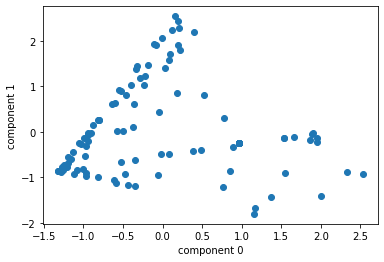

In [65]:
n_components=3

X = gut_data.fluxes.copy()
## fluxes tend to stratify based on genus... thus look at medium fluxes instead
X = get_medium_fluxes(X)

X = gut_data.X_df.copy()

X_scale = mb_utils.scale_inputs(X,  pd_bool=False)
# X_scale = mb_utils.scale_inputs_minmax(X,  pd_bool=False)

pca = PCA(n_components=n_components, whiten=True)
X_pca = pca.fit_transform(X_scale)
X_pca_df = pd.DataFrame(X_pca, index=X.index, columns=range(n_components))
X_pca_df.columns = ["PCA comp "+str(x) for x in X_pca_df.columns]
### Get matrix of pca weights as well
pca_weight_df = pd.DataFrame(pca.components_,index=X_pca_df.columns,columns=X.columns).T

print(pca.explained_variance_ratio_)
plt.scatter(X_pca[:, 0], X_pca[:, 1],
            # c=digits.target, edgecolor='none', alpha=0.5,
            #cmap=plt.cm.get_cmap('spectral', 10)
            )
plt.xlabel('component 0')
plt.ylabel('component 1')
# plt.colorbar();

In [63]:
PCA_weight_df[2].sort_values()

react
EX_rsv_m__medium         -0.121277
EX_ptvst_m__medium       -0.121277
EX_lac_L_m__medium       -0.105275
EX_glyc_m__medium        -0.104670
EX_no2_m__medium         -0.103942
                            ...   
EX_ptrc_m__medium         0.108995
EX_trp_L_m__medium        0.109058
EX_thm_m__medium          0.109222
EX_rsvgluc_m__medium      0.121277
EX_ptvstgluc_m__medium    0.121277
Name: 2, Length: 621, dtype: float64

In [51]:
gut_data.X_df.loc["10317.000002649"]

christensenellaceae    0.066672
bilophila              0.156475
alistipes              0.774212
corynebacterium        0.001320
staphylococcus         0.001320
Name: 10317.000002649, dtype: float64

In [8]:
gut_data.get_num_metadata_df()

In [37]:
num_metadata_fstat_df = pd.DataFrame()
num_metadata_pval_df = pd.DataFrame()

y_num_corr_df = gut_data.num_metadata_df.loc[X_pca_df.index].copy()
y_num_corr_df = y_num_corr_df[y_num_corr_df.columns[y_num_corr_df.std()>1e-3]]
y_num_corr_df = y_num_corr_df[y_num_corr_df.columns[y_num_corr_df.sum()>1]]

drop_cols = [x for x in y_num_corr_df.columns if "host_subject_id" in x or "survey_id_" in x or "anonymized_name" in x or "bmi_" in x or "collection_timestamp_" in x or "collection_time_" in x]
# drop_cols = [x for x in y_num_corr_df.columns if "bmi_" in x]
y_num_corr_df.drop(drop_cols,axis=1,inplace=True)

print(y_num_corr_df.shape)
for col in y_num_corr_df.columns[1:1000]:
    f_stat, p_val = f_classif(X_pca_df, y_num_corr_df[col])
    ## f_stat_df
    f_stat_df = pd.DataFrame(f_stat, index=X_pca_df.columns, columns=[col])
    num_metadata_fstat_df = pd.concat([num_metadata_fstat_df, f_stat_df],axis=1)

    ## p_val_df
    p_val_df = pd.DataFrame(p_val, index=X_pca_df.columns, columns=[col])
    num_metadata_pval_df = pd.concat([num_metadata_pval_df, p_val_df],axis=1)

num_metadata_pval_df = num_metadata_pval_df.T
num_metadata_fstat_df = num_metadata_fstat_df.T

(109, 1076)


In [39]:
num_metadata_pval_df["PCA comp 0"].sort_values()

state_il                                  0.000199
longitude_-88.0                           0.000271
acne_medication_otc_yes                   0.000403
weight_kg_81.0                            0.000575
age_cat_20s                               0.000602
                                            ...   
fed_as_infant_primarily infant formula    0.997544
whole_grain_frequency_daily               0.998558
olive_oil_daily                           0.999171
asd_i do not have this condition          0.999681
consume_animal_products_abx_no            0.999758
Name: PCA comp 0, Length: 999, dtype: float64

<AxesSubplot:xlabel='PCA comp 0', ylabel='PCA comp 1'>

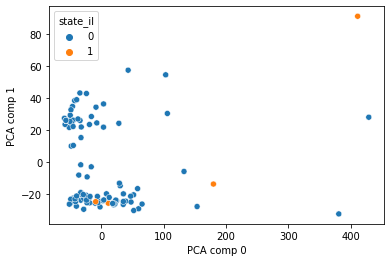

In [42]:
X_pca_trait_df = pd.concat([X_pca_df, gut_data.num_metadata_df.loc[X_pca_df.index]],axis=1)
# X_pca_df

sns.scatterplot(data=X_pca_trait_df, x="PCA comp 0", y="PCA comp 1", hue="state_il")

Look at weight matrix

# Predict traits using fluxes and abundances

In [5]:
gut_data = gd.GutData()
gut_data.load_data(
    # FILE_COMM_MODEL='../data/reconstructions/community_5_TOP-vegan.pickle',
    FILE_COMM_MODEL= DATA_LOC + 'reconstructions/community_5_TOP-vegan.pickle',
    # FILE_GENUS_ASVS = "../data/agp_data/taxon_genus_asvs.csv",
    FILE_GENUS_ASVS = DATA_LOC + 'agp_data/taxon_genus_asvs.csv',
    # FILE_METADATA = DATA_LOC + "agp_data/mcdonald_agp_metadata.txt",
    FILE_METADATA = DATA_LOC + "agp_data/metadata_biosample_filtered.csv",
    DIR_SIM_DATA = DATA_LOC + "micom-sim-data/"  # "../data/micom-sim-data/",
)
gut_data.norm_abundances(filter_model=True, add_delta=True) ## Filters genus to those in model, adds small value to abundaces
gut_data.X_df = gut_data.asv_df.T.copy()
gut_data.sample_list = gut_data.X_df.index.to_list()
gut_data.set_vegan_df(sample_num=40)
## Set vegan df changes X_df and y_df and will therefore change medium_df. Be sure to run medium df after setting samples
medium_df = pd.DataFrame(1000, columns=gut_data.com_model.medium.keys(), index = gut_data.X_df.index)
gut_data.sample_medium_dict = medium_df.T.to_dict()
gut_data.return_fluxes = True
gut_data.pfba_bool = True # otherwise optimum values will not be fluxes but intead min(sum flux)

Nothing to fix
... normalizing raw ASV abundances to fractions, dropping samples with 0 total abundances
# of genus in model and not filterd out of QA/QC: 5, # of genus not in model:0


In [67]:
%%time
# using Cooperative Tradeoff, 9mins 12seconds for 1000 samples 
gut_data.tradeoff_bool = True
gut_data.tradeoff_frac = 0.1
# gut_data.sample_list = gut_data.X_df.index[:10].to_list() # using 10 samples in this case
gut_data.run_micom_samples_parallel(gut_data.com_model, processes=gd.cpu_count(), atol=1e-6)
# print(gut_data.compute_results)

CPU times: user 375 ms, sys: 844 ms, total: 1.22 s
Wall time: 29 s


Looping through list of traits

In [74]:
fluxes_df = pd.read_csv(gut_data.dir_sim_data+"micom_fluxes-top5-%d_samples.csv"%(len(gut_data.sample_list)),index_col=0)

In [78]:
gut_data.get_num_metadata_df()

In [79]:
for col in gut_data.num_metadata_df.columns:
    if "ibs" in col:
        print(col)

ibs_diagnosed by a medical professional (doctor, physician assistant)
ibs_diagnosed by an alternative medicine practitioner
ibs_i do not have this condition
ibs_not provided
ibs_self-diagnosed
ibs_unknown
pm_gastro_problems_irritable_bowel_syndrome_ibs_not provided


In [11]:
sample_num = 40
for trait_id in ["vegan", "ibs"]:
    gut_data = gd.GutData()
    gut_data.load_data(
        # FILE_COMM_MODEL='../data/reconstructions/community_5_TOP-vegan.pickle',
        FILE_COMM_MODEL= DATA_LOC + 'reconstructions/community_5_TOP-vegan.pickle',
        # FILE_GENUS_ASVS = "../data/agp_data/taxon_genus_asvs.csv",
        FILE_GENUS_ASVS = DATA_LOC + 'agp_data/taxon_genus_asvs.csv',
        # FILE_METADATA = DATA_LOC + "agp_data/mcdonald_agp_metadata.txt",
        FILE_METADATA = DATA_LOC + "agp_data/metadata_biosample_filtered.csv",
        DIR_SIM_DATA = DATA_LOC + "micom-sim-data/"  # "../data/micom-sim-data/",
    )
    gut_data.norm_abundances(filter_model=True, add_delta=True) ## Filters genus to those in model, adds small value to abundaces
    gut_data.X_df = gut_data.asv_df.T.copy()
    gut_data.sample_list = gut_data.X_df.index.to_list()
    if trait_id=="vegan":
        gut_data.set_vegan_df(sample_num=sample_num)
    elif trait_id=="ibs":
        gut_data.set_ibs_df(sample_num=sample_num, add_other_diagnosis=False)
    ## Set vegan df changes X_df and y_df and will therefore change medium_df. Be sure to run medium df after setting samples
    medium_df = pd.DataFrame(1000, columns=gut_data.com_model.medium.keys(), index = gut_data.X_df.index)
    gut_data.sample_medium_dict = medium_df.T.to_dict()

    # gut_data.fluxes.to_csv(gut_data.dir_sim_data+"micom_fluxes-%s.csv"%(trait_id))
    gut_data.X_df.to_csv(gut_data.dir_sim_data+"micom_X_df-%s.csv"%(trait_id))
    gut_data.y_df.to_csv(gut_data.dir_sim_data+"micom_y_df-%s.csv"%(trait_id))

Nothing to fix
... normalizing raw ASV abundances to fractions, dropping samples with 0 total abundances
# of genus in model and not filterd out of QA/QC: 5, # of genus not in model:0
Nothing to fix
... normalizing raw ASV abundances to fractions, dropping samples with 0 total abundances
# of genus in model and not filterd out of QA/QC: 5, # of genus not in model:0


In [ ]:
gut_data.fluxes.to_csv(gut_data.dir_sim_data+"micom_fluxes-%s.csv"%(trait_id))

# Build simple ML models using either fluxes or abundances as inputs and compare results

In [17]:
def filter_X_cols(X_df, std_thresh=1e-3, verbose=False):
    """Drop features in X_df that are all 0, or the same number (or have very little std)"""
    if verbose==True:
        print(X_df.shape)
    X_df = X_df[X_df.columns[X_df.std()>std_thresh]]
    if verbose==True:
        print(X_df.shape)
    return X_df

def match_Xy_df(X_in_df, y_in_df):
    X_df, y_df = X_in_df.copy(), y_in_df.copy()
    """ Makes sure X_df and y_df have the same indices"""
    overlap = list(set(X_df.index).intersection(set(y_df.index)))
    X_df =  X_df.loc[overlap]
    y_df =  y_df.loc[overlap]
    return X_df, y_df

In [18]:
# FLUX_DF_NAME = "micom_fluxes-top5-109_samples.csv"
FLUX_DF_NAME = "micom_medium-fluxes-top5-736_samples.csv"
X_flux = pd.read_csv(gut_data.dir_sim_data+FLUX_DF_NAME,index_col=0)
X_flux.index = X_flux.index.astype(str)

# FLUX_DF_NAME = "micom_fluxes-top5-736_samples.csv"
# X_flux = pd.read_csv(gut_data.dir_sim_data+FLUX_DF_NAME,index_col=0, chunksize=50)
# X_flux.index = X_flux.index.astype(str)
# for x_flux_df in X_flux:
#     print(x_flux_df.shape)

Takes about 6 minutes to run for 200 samples...

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif

In [16]:
# RFE test
n_splits = 5 #10
test_size = 0.25
n_features = 50
input_type = "vegan"

# y_df=pd.read_csv(gut_data.dir_sim_data+"micom_y_df-%s.csv"%(input_type),index_col=0)
# y_df = y_df[y_df.columns[0]]
y_df = gut_data.y_df.copy()

X, y = match_Xy_df(X_flux, y_df)
# X = mb_utils.filter_X_cols(X)
X, y = X.values, y.values

feat_filter = RFE(estimator=gut_data.logreg, n_features_to_select=n_features)
# feat_filter = SelectKBest(f_classif, k=n_features)

skf = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size)
# model = make_pipeline(SMOTE(),gut_data.logreg)
# model = make_pipeline(RandomOverSampler(),gut_data.logreg)
model = make_pipeline(StandardScaler(), RandomOverSampler(), feat_filter, gut_data.logreg)

# n_scores = cross_val_score(model, X, y, scoring=['accuracy', 'roc_auc'], cv=skf, n_jobs=-1, error_score='raise')
n_scores = cross_validate(model, X, y, scoring=['accuracy','balanced_accuracy','roc_auc','average_precision'], cv=skf, n_jobs=-1, error_score='raise')
print(np.mean(n_scores["test_accuracy"]), np.mean(n_scores["test_roc_auc"]))
n_scores

0.85 0.6626488095238094


{'fit_time': array([66.82487249, 43.6760633 , 58.04426527, 56.30538225, 56.66689277]),
 'score_time': array([0.00154233, 0.00170565, 0.00137925, 0.00148082, 0.00140953]),
 'test_accuracy': array([0.82692308, 0.84615385, 0.86538462, 0.82692308, 0.88461538]),
 'test_roc_auc': array([0.62585034, 0.63945578, 0.59895833, 0.57823129, 0.8707483 ])}

In [40]:
gut_data.logreg.penalty

'l2'

In [8]:
##### -------- Iterate over different ML params ---------
## FLUX_DF_NAME = "micom_fluxes-top5-109_samples.csv"
FLUX_DF_NAME = "micom_medium-fluxes-top5-736_samples.csv"
X_flux = pd.read_csv(gut_data.dir_sim_data+FLUX_DF_NAME,index_col=0)
X_flux.index = X_flux.index.astype(str)

# RFE test
n_splits = 10 #10
test_size = 0.25
# input_type = "vegan"
input_type = "ibs"

y_df = gut_data.y_df.copy()
X, y = match_Xy_df(X_flux, y_df)
# X, y = match_Xy_df(gut_data.X_df, y_df)
# X = mb_utils.filter_X_cols(X)
X, y = X.values, y.values

score_list = ['accuracy','balanced_accuracy','roc_auc','average_precision']

param_score_dict = {}
for c_param in [1e-3, 1e-2, 1e-1, 1, 5, 1e1, 1e2, 1e3]:
    for n_features in [5, 10, 15, 20, 35, 50]:
        for penalty_param in ["l1", "l2"]:

            gut_data.logreg.C = c_param
            gut_data.logreg.penalty = penalty_param

            # feat_filter = RFE(estimator=gut_data.logreg, n_features_to_select=n_features)
            feat_filter = SelectKBest(f_classif, k=n_features)

            skf = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size)
            model = make_pipeline(StandardScaler(), SMOTE(), feat_filter, gut_data.logreg)
            # model = make_pipeline(StandardScaler(), RandomOverSampler(), feat_filter, gut_data.logreg)
            n_scores = cross_validate(model, X, y, scoring=score_list, cv=skf, n_jobs=-1, error_score='raise')
            score_dict = {score_id: n_scores["test_"+score_id].mean() for score_id in score_list}
            param_score_dict.update({(c_param, n_features, penalty_param): score_dict})

score_df = pd.DataFrame(param_score_dict).T

In [9]:
score_df.sort_values(["balanced_accuracy", "roc_auc"],ascending=False).head()

,,,accuracy,balanced_accuracy,roc_auc,average_precision
0.100,15,l2,0.675472,0.698214,0.743367,0.232926
0.010,10,l2,0.616981,0.689541,0.706122,0.156832
0.001,35,l2,0.460377,0.685204,0.729082,0.188902
0.010,35,l2,0.626415,0.683163,0.713265,0.211031
100.000,10,l1,0.750943,0.670153,0.704082,0.223658


In [12]:
writer = pd.ExcelWriter(gut_data.dir_sim_data+'ml_params.xlsx')
score_df.to_excel(writer, "ibs"+"_"+"flux")
writer.save()

In [20]:
gut_data.dir_sim_data

'../../../Data/microbiome_xai/micom-sim-data/'

In [21]:
score_df.index

MultiIndex([( 0.001,  5, 'l1'),
            ( 0.001,  5, 'l2'),
            ( 0.001, 10, 'l1'),
            ( 0.001, 10, 'l2'),
            ( 0.001, 15, 'l1'),
            ( 0.001, 15, 'l2'),
            ( 0.001, 20, 'l1'),
            ( 0.001, 20, 'l2'),
            ( 0.001, 35, 'l1'),
            ( 0.001, 35, 'l2'),
            ( 0.001, 50, 'l1'),
            ( 0.001, 50, 'l2'),
            (  0.01,  5, 'l1'),
            (  0.01,  5, 'l2'),
            (  0.01, 10, 'l1'),
            (  0.01, 10, 'l2'),
            (  0.01, 15, 'l1'),
            (  0.01, 15, 'l2'),
            (  0.01, 20, 'l1'),
            (  0.01, 20, 'l2'),
            (  0.01, 35, 'l1'),
            (  0.01, 35, 'l2'),
            (  0.01, 50, 'l1'),
            (  0.01, 50, 'l2'),
            (   0.1,  5, 'l1'),
            (   0.1,  5, 'l2'),
            (   0.1, 10, 'l1'),
            (   0.1, 10, 'l2'),
            (   0.1, 15, 'l1'),
            (   0.1, 15, 'l2'),
            (   0.1, 20, 'l1'),
        

In [73]:
score_df.sort_values(["balanced_accuracy", "roc_auc"],ascending=False).head()

,,,accuracy,balanced_accuracy,roc_auc,average_precision
1.000,15,l1,0.755769,0.738138,0.777721,0.227143
0.001,10,l2,0.494231,0.705602,0.735868,0.186809
0.100,10,l2,0.674038,0.701499,0.729645,0.159949
0.001,35,l2,0.468269,0.701424,0.757781,0.211122
0.100,20,l2,0.684615,0.697715,0.760767,0.222313


In [79]:
score_df.sort_values(["balanced_accuracy", "roc_auc"],ascending=False).head()

,,,accuracy,balanced_accuracy,roc_auc,average_precision
5.000,35,l2,0.755769,0.763467,0.795849,0.217643
0.001,5,l2,0.535577,0.733684,0.771253,0.201962
100.000,15,l2,0.766346,0.729114,0.786001,0.240652
0.001,10,l2,0.504808,0.718559,0.717990,0.170939
10.000,50,l2,0.761538,0.708780,0.763069,0.195587


In [83]:
feat_filter.__class__.__name__

'SelectKBest'

In [63]:
X_flux.columns[selector.support_]

Index(['EX_3mop_m__medium', 'EX_acald_m__medium', 'EX_ade_m__medium',
       'EX_asn_L_m__medium', 'EX_cgly_m__medium', 'EX_dgsn_m__medium',
       'EX_for_m__medium', 'EX_glcn_m__medium', 'EX_glyc3p_m__medium',
       'EX_glyleu_m__medium', 'EX_ha_deg1_m__medium', 'EX_ile_L_m__medium',
       'EX_mnl_m__medium', 'EX_nadp_m__medium', 'EX_ncam_m__medium',
       'EX_nmn_m__medium', 'EX_ser_L_m__medium', 'EX_thr_L_m__medium',
       'EX_ttdca_m__medium', 'EX_ura_m__medium'],
      dtype='object')

In [17]:
n_splits = 5 #10
test_size = 0.25

input_type_aucs_long = pd.DataFrame()
for input_type in ["vegan", "ibs"][:]: # , "ibs"

    ### Code here initializes the data set (gut_data object)
    ### ...
    ### ...
    # y_df=pd.read_csv(gut_data.dir_sim_data+"micom_y_df-%s.csv"%(input_type),index_col=0)
    # y_df = y_df[y_df.columns[0]]
    y_df = gut_data.y_df.copy()

    ml_data_dict = {}
    for data_fit in ["flux", "abundance"]:
        if data_fit == "flux":
            ### This should change to loading the computed data
            X, y = match_Xy_df(X_flux, y_df)
            X = mb_utils.filter_X_cols(X)
            X, y = X.values, y.values
             # remove features that don't change...
        else:
            # X = pd.read_csv(gut_data.dir_sim_data+"micom_X_df-%s.csv"%(input_type),index_col=0)
            X = gut_data.X_df.copy()
            X, y = match_Xy_df(X, y_df)
            X, y = X.values, y.values
            
        ### LogReg
        skf = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size)

        # model = make_pipeline(RandomOverSampler(), gut_data.logreg)

        rfe = RFE(estimator=gut_data.logreg, n_features_to_select=5)
        model = make_pipeline(RandomOverSampler(), rfe, gut_data.logreg)
        # model = make_pipeline(SMOTE(),gut_data.logreg)

        n_scores = cross_validate(model, X, y, scoring=['accuracy', 'roc_auc'], cv=skf, n_jobs=-1, error_score='raise')
        ml_data_dict.update({
            data_fit: {
                "aucs": n_scores["test_roc_auc"],
                "aps": n_scores["test_accuracy"]
            }
        })
        
        
        # recall_vals, precision_vals, avg_AP, tpr_vals, fpr_vals, avg_AUC, auc_list, ap_list = mb_utils.get_PR_ROC(
        #     model, skf, X, y, bool_scale_inputs=True)
        # ml_data_dict.update({
        #     data_fit: {
        #         "aucs": auc_list,
        #         "aps": ap_list
        #     }
        # })

    ml_data_df = pd.DataFrame.from_dict(ml_data_dict,orient="index")
    ml_data_df.reset_index(inplace=True)
    ml_data_df_long = ml_data_df.explode("aucs",ignore_index=True)[["index","aucs"]]
    for col in ["aps"]:
        ml_data_df_long = pd.concat([ml_data_df_long, ml_data_df.explode(col,ignore_index=True)[col]],axis=1)

    ml_data_df_long["aucs"] = ml_data_df_long["aucs"].astype(float)
    ml_data_df_long["input_type"] = input_type
    input_type_aucs_long = pd.concat([input_type_aucs_long, ml_data_df_long])

Text(0.5, 1.0, 'LogReg AUCs comparison')

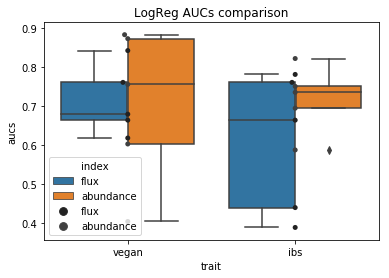

In [18]:
f, ax = plt.subplots()
# ax = sns.barplot(x="index", y="aucs", hue="input_type", data=input_type_aucs_long, palette="Set2")
# ax = sns.barplot(x="input_type", y="aucs", hue="index", data=input_type_aucs_long, palette="Set2")
ax = sns.boxplot(x="input_type", y="aucs", hue="index", data=input_type_aucs_long)
ax = sns.swarmplot(x="input_type", y="aucs", hue="index", data=input_type_aucs_long, color=".25")
# ax.set_ylabel("features")
ax.set_xlabel("trait")
ax.set_title("LogReg AUCs comparison")
# f.savefig(FIG_SAVE_LOC+"LogReg_aucs_comparison.svg")
# f.savefig(FIG_SAVE_LOC+"LogReg_aucs_comparison.png")

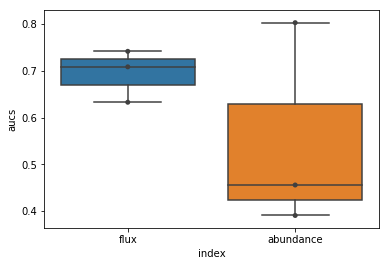

In [87]:
ml_data_df = pd.DataFrame.from_dict(ml_data_dict,orient="index")
ml_data_df.reset_index(inplace=True)

# ml_data_df_long = pd.DataFrame()
# ml_data_df = ml_data_df.explode("aucs",ignore_index=True)
ml_data_df_long = ml_data_df.explode("aucs",ignore_index=True)[["index","aucs"]]
for col in ["aps"]:
    ml_data_df_long = pd.concat([ml_data_df_long, ml_data_df.explode(col,ignore_index=True)[col]],axis=1)

ml_data_df_long["aucs"] = ml_data_df_long["aucs"].astype(float)
# ax = sns.boxplot(x="aucs", y="index", orient="h", data=ml_data_df_long)
# ax = sns.swarmplot(x="aucs", y="index", orient="h", data=ml_data_df_long, color=".25")
ax = sns.boxplot(x="index", y="aucs", orient="v", data=ml_data_df_long)
ax = sns.swarmplot(x="index", y="aucs", orient="v", data=ml_data_df_long, color=".25")

In [ ]:
f, ax = plt.subplots()
ax = sns.barplot(x="index", y="aucs", hue="input_type", data=input_type_aucs_long, palette="Set2")
# ax.set_ylabel("features")
# ax.set_xlabel("rf importance")
ax.set_title("rf aucs comparison")
f.savefig(FIG_SAVE_LOC+"rf_aucs_comparison.svg")
f.savefig(FIG_SAVE_LOC+"rf_aucs_comparison.png")

### Precision Recall curves if desired...

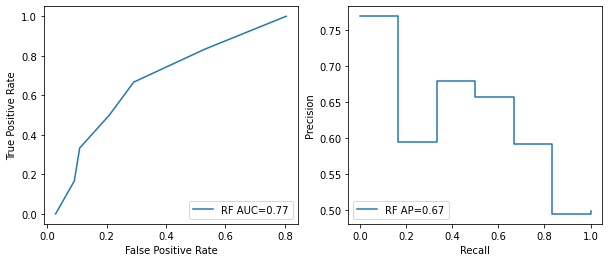

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
n_splits = 10
test_size = 0.3
X, y = gut_data.fluxes.values, gut_data.y_df.values
skf = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size)
# skf = ShuffleSplit(n_splits=n_splits, test_size=test_size)

### LogReg
model = make_pipeline(SMOTE(),gut_data.logreg)
recall_vals, precision_vals, avg_AP, tpr_vals, fpr_vals, avg_AUC = mb_utils.get_PR_ROC(
    model, skf, X, y, bool_scale_inputs=True)

pr_display = PrecisionRecallDisplay(precision=precision_vals, recall=recall_vals)
roc_display = RocCurveDisplay(fpr=fpr_vals, tpr=tpr_vals)

roc_display.plot(ax=ax1, label='RF AUC={0:0.2f}'.format(avg_AUC))
pr_display.plot(ax=ax2, label='RF AP={0:0.2f}'.format(avg_AP))

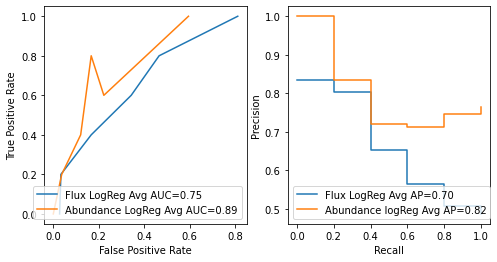

In [7]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
n_splits = 5
test_size = 0.5
## Flux fit with logistic regression
X, y = gut_data.fluxes.values, gut_data.y_df.values
skf = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size)
### LogReg
model = make_pipeline(SMOTE(),gut_data.logreg)
recall_vals, precision_vals, avg_AP, tpr_vals, fpr_vals, avg_AUC = mb_utils.get_PR_ROC(
    model, skf, X, y, bool_scale_inputs=True)
pr_display = PrecisionRecallDisplay(precision=precision_vals, recall=recall_vals)
roc_display = RocCurveDisplay(fpr=fpr_vals, tpr=tpr_vals)

roc_display.plot(ax=ax1, label='Flux Avg AUC={0:0.2f}'.format(avg_AUC))
pr_display.plot(ax=ax2, label='Flux Avg AP={0:0.2f}'.format(avg_AP))

## Gut abundance fit with logistic regression
X, y = gut_data.X_df.values, gut_data.y_df.values
### LogReg
model = make_pipeline(SMOTE(),gut_data.logreg)
recall_vals, precision_vals, avg_AP, tpr_vals, fpr_vals, avg_AUC = mb_utils.get_PR_ROC(
    model, skf, X, y, bool_scale_inputs=True)
pr_display = PrecisionRecallDisplay(precision=precision_vals, recall=recall_vals)
roc_display = RocCurveDisplay(fpr=fpr_vals, tpr=tpr_vals)

roc_display.plot(ax=ax1, label='Abundance Avg AUC={0:0.2f}'.format(avg_AUC), c="red")
pr_display.plot(ax=ax2, label='Abundance Avg AP={0:0.2f}'.format(avg_AP), c="red")

In [28]:
# sol = gut_learn.com_model.optimize(fluxes=True)
# gresults = gl.get_micom_results(gut_learn.com_model, sol, tradeoff=1, atol=1e-6)
# gresults.growth_rates

# Correlate growth fluxes with traits

In [3]:
from sklearn.feature_selection import f_classif, f_regression

In [4]:
X_df = gut_learn.X_df
f_flux_opt, pval_flux_opt = f_classif(X_df, gut_learn.y_df)
pval_flux_opt_df = pd.DataFrame(pval_flux_opt,index=X_df.columns, columns=['pval'])
pval_flux_opt_df.sort_values('pval',ascending=True,inplace=True)
pval_flux_opt_df

,pval
alistipes,1.253417e-07
corynebacterium,7.732097e-04
staphylococcus,6.056109e-03
christensenellaceae,1.277991e-02
bilophila,6.272631e-02


In [5]:
# X_df = fluxes
X_df = gut_learn.fluxes

X_df = X_df[X_df.columns[X_df.std()>1e-6]] # fitler constant flux
f_flux_opt, pval_flux_opt = f_classif(X_df, gut_learn.y_df)
pval_flux_opt_df = pd.DataFrame(pval_flux_opt,index=X_df.columns, columns=['pval'])
pval_flux_opt_df.sort_values('pval',ascending=True,inplace=True)
pval_flux_opt_df

/home/eskavvas/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [2809 2810 2836 3155 3172 3210 3277 3361 3386 3408 3409 3581 3582 3583
 3652 3658 3705 3706 3719 3803 3845 3846 7653 7894 8039 8327] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/eskavvas/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/home/eskavvas/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


,pval
react,
MLTG3__corynebacterium,0.0
GLCURt2r__corynebacterium,0.0
ACONTb__corynebacterium,0.0
O2t__corynebacterium,0.0
ACONTa__corynebacterium,0.0
...,...
TDPGAT__staphylococcus,NaN
G3PAT140__christensenellaceae,NaN
TDCOATA__christensenellaceae,NaN


In [8]:
# X_df = pd.DataFrame(grates_df)
X_df = gut_learn.member_growth_rates

X_df = X_df[X_df.columns[X_df.std()>1e-6]] # fitler constant flux
f_flux_opt, pval_flux_opt = f_classif(X_df, gut_learn.y_df)
pval_flux_opt_df = pd.DataFrame(pval_flux_opt,index=X_df.columns, columns=['pval'])
pval_flux_opt_df.sort_values('pval',ascending=True,inplace=True)
pval_flux_opt_df

,pval
compartments,
christensenellaceae,0.059042
bilophila,0.096870
alistipes,0.149993
corynebacterium,NaN
staphylococcus,NaN
